In [1]:
import pandas as pd
# Load the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
# Check for missing values
print(df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [2]:
import pandas as pd
import numpy as np
df_raw = pd.read_csv('healthcare-dataset-stroke-data.csv')
df_raw.head()

df_raw['bmi'].fillna(df['bmi'].mean(), inplace=True)

cat_cols = list(df_raw.select_dtypes(include=object))
# Layout dictionaries to categorize columns
sex_map = {
    "Male": 1,
    "Female": 2,
    "Other": 3
}
ever_married_map = {
    "Yes": 1,
    "No": 2
}
work_type_map = {
    "Private": 1,
    "Self-employed": 2,
    "Govt_job": 3,
    "children": 4,
    "Never_worked": 5
}
residence_type_map = {
    "Urban": 1,
    "Rural": 2
}
somking_status_map = {
    "formerly smoked": 1,
    "never smoked": 2,
    "smokes": 3,
    "Unknown": 4
}

# Set aside the pristine primary dataframe
df = df_raw
# Create cat dataframe temporarily
df_cat = df 

df_cat["gender"].replace(sex_map, inplace=True)
df_cat["ever_married"].replace(ever_married_map, inplace=True)
df_cat["work_type"].replace(work_type_map, inplace=True)
df_cat["Residence_type"].replace(residence_type_map, inplace=True)
df_cat["smoking_status"].replace(somking_status_map, inplace=True)

df_cat["stroke"] = df_cat["stroke"].astype(np.int64)

# Convert strings / categorical data back into int64 for modelling purposes
for col in cat_cols: 
    df_cat[col] = df_cat[col].astype(int) 

# Clone dataframe for ML ops
df = df_cat
df.drop('id', axis=1, inplace=True)
df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,1,1,228.69,36.600000,1,1
1,2,61.0,0,0,1,2,2,202.21,28.893237,2,1
2,1,80.0,0,1,1,1,2,105.92,32.500000,2,1
3,2,49.0,0,0,1,1,1,171.23,34.400000,3,1
4,2,79.0,1,0,1,2,2,174.12,24.000000,2,1
5,1,81.0,0,0,1,1,1,186.21,29.000000,1,1
6,1,74.0,1,1,1,1,2,70.09,27.400000,2,1
7,2,69.0,0,0,2,1,1,94.39,22.800000,2,1
8,2,59.0,0,0,1,1,2,76.15,28.893237,4,1
9,2,78.0,0,0,1,1,1,58.57,24.200000,4,1


In [3]:
##List of Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, log, sqrt
from qiskit import Aer, assemble, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
qasm_sim = Aer.get_backend('qasm_simulator') # To use local qasm simulator

In [4]:
dataset = np.array(df.iloc[:,:-1]).astype(float)
assigned = df.iloc[:, -1]

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)
n_components = 2  # Number of principal components
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

# Transform the standardized features to the first 'n_components' principal components
X_pca = pca.transform(X_scaled)
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X = min_max_scaler.fit_transform(X_pca)

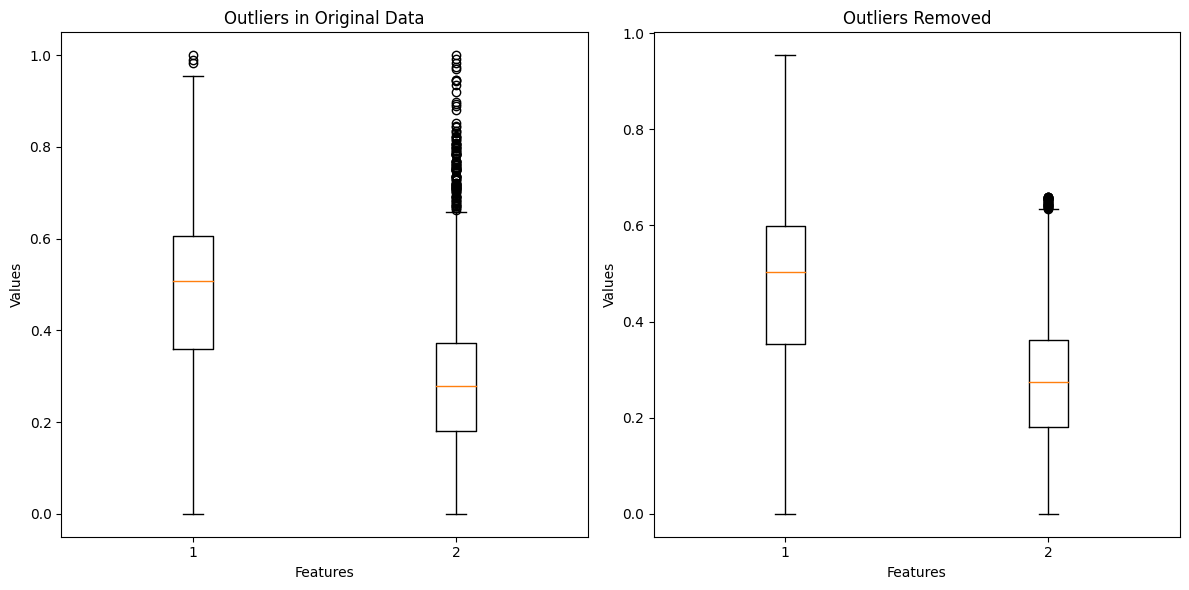

In [5]:
import numpy as np

# Calculate the IQR for each column
Q1 = np.percentile(X, 25, axis=0)
Q3 = np.percentile(X, 75, axis=0)
IQR = Q3 - Q1

# Define the threshold for outlier detection
threshold = 1.5

# Create a boolean mask for outliers
outliers_mask = ((X < (Q1 - threshold * IQR)) | (X > (Q3 + threshold * IQR)))

# Count the number of outliers in each row
num_outliers = np.sum(outliers_mask, axis=1)

# Visualize outliers before and after filtering
plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(1, 2, 1)
plt.boxplot(X)
plt.title('Outliers in Original Data')
plt.xlabel('Features')
plt.ylabel('Values')

# Filter out rows with at least one outlier
filtered_mask = num_outliers == 0
X = X[filtered_mask]
assigned = assigned[filtered_mask]

# Plot filtered data
plt.subplot(1, 2, 2)
plt.boxplot(X)
plt.title('Outliers Removed')
plt.xlabel('Features')
plt.ylabel('Values')

# Display the plot
plt.tight_layout()
plt.show()

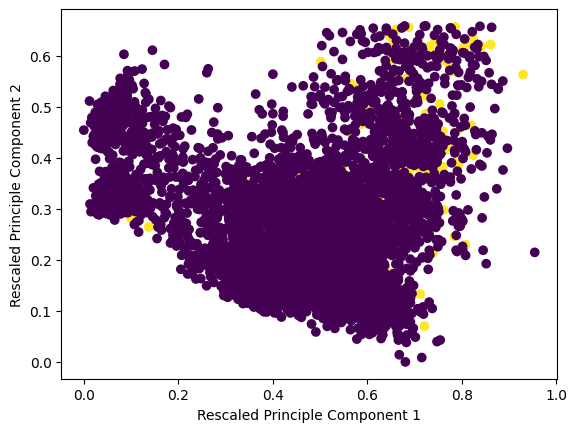

In [6]:
plt.scatter(X[:,0],X[:,1], c=assigned)
plt.xlabel("Rescaled Principle Component 1")
plt.ylabel("Rescaled Principle Component 2")
plt.show()

In [7]:
import time 
def concatenate(data,centres):
    
    centres = np.array([centres])
    lenX,N = data.shape
    n = ceil(log(N,2))+1

    result = np.zeros((lenX,2**n))
    result[:,:N] = data[:,:]
    result[:,(2**(n-1)):(2**(n-1)+N)] = centres
   
    return result

def Q_distance(data,centres,iteration=1024): 

    N = data.shape[1]
    n = ceil(log(N,2))+1 
    mat = concatenate(data,centres) 

    norm = np.linalg.norm(mat,axis=1)
    initial_states = mat/norm[:,None]

    dist = np.zeros([initial_states.shape[0],1])
    start_time = time.time()
    for i,state in enumerate(initial_states):

        qr = QuantumRegister(n)
        cr = ClassicalRegister(1)
        qc = QuantumCircuit(qr,cr)
        qc.initialize(state,[qr[::-1]])
        qc.h(qr[0])
        qc.measure(qr[0],cr[0])
        
        
        qobj = assemble(qc, shots=iteration)
        counts = qasm_sim.run(qobj).result().get_counts()

        if len(counts) == 1:
            dist[i] = 0
        else:
            dist[i] = norm[i]*sqrt(2*(counts["1"]/iteration))
    
    end_time = time.time()
    execution_time = (end_time - start_time)/data.shape[0]
    print(f"Execution Time: {execution_time} seconds")
    return dist

def initialise_centres(data,K):
    
    i = np.random.choice(data.shape[0])
    centres = np.array([data[i, :]])
    
    for k in range(0,K):
        if k == 0:
            distance = Q_distance(data, centres[k])
            prob = distance/np.sum(distance)
            
        else:
            distance_1 = Q_distance(data, centres[k])
            distance = np.concatenate((distance,distance_1),axis=1)
            
            min_distance = np.min(distance, axis = 1)
            
            prob = min_distance/np.sum(min_distance)
            
        if k != (K-1):
            centres_new = data[np.random.choice(data.shape[0], p = prob.flatten())]  
            centres = np.append(centres, np.array([centres_new]), axis=0)

    return distance, centres 

def nearest_cluster(distances):
    
    assigned = np.zeros(len(distances))
    
    for n,i in enumerate(distances):
        # print(n)
        assigned[n] = np.argmin(i)
        
    return assigned
    
def find_new_centres(data,assigned,k,n):
     
    new_centres = np.zeros([k,n])
    
    for i in range(k):
        new_centres[i,:] = np.average(data[assigned==i],axis=0)
        
    return new_centres

Execution Time: 0.008314379472057765 seconds
Execution Time: 0.0075879436763595974 seconds
------  Iteration:  1 ------


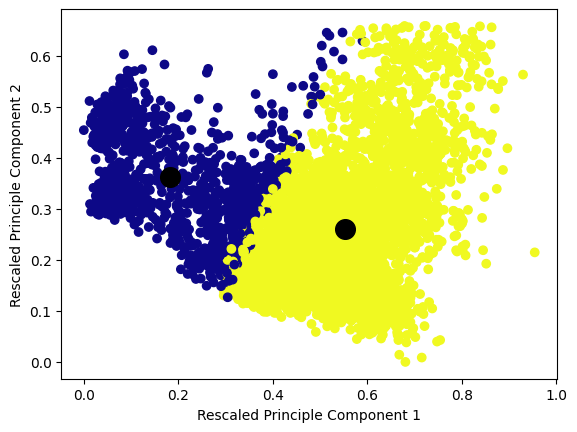

0.15350513993280723
Not Converged
------  Iteration:  2 ------
Execution Time: 0.008596497371503073 seconds
Execution Time: 0.009238510003761816 seconds


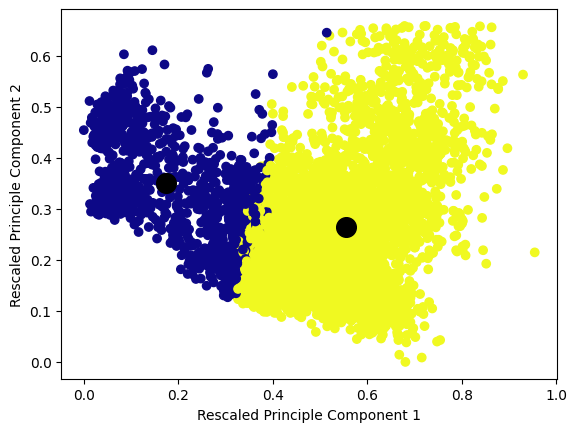

0.015491204655633771
Not Converged
------  Iteration:  3 ------
Execution Time: 0.009108816174759275 seconds
Execution Time: 0.0090621464427857 seconds


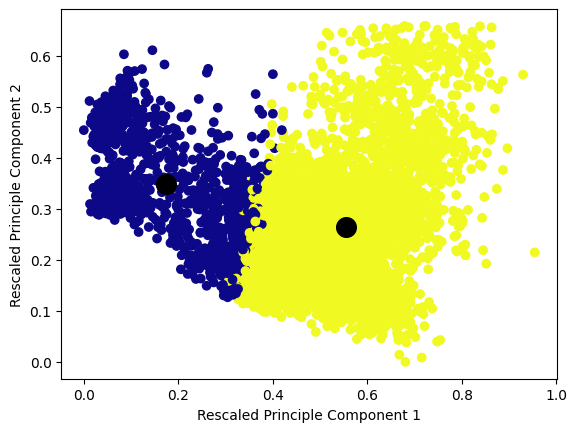

0.002147586172288243
Not Converged
------  Iteration:  4 ------
Execution Time: 0.009312598684742542 seconds
Execution Time: 0.008812193546536022 seconds


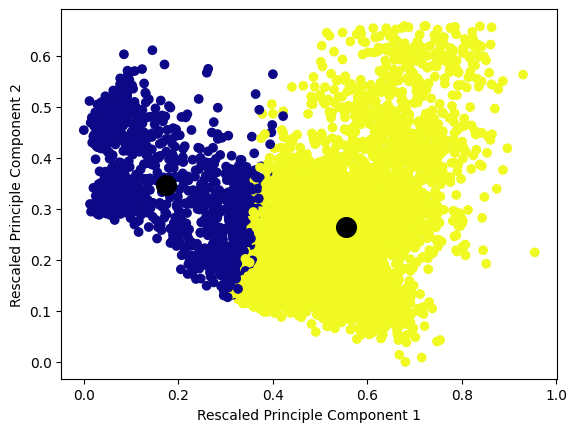

0.0006535891505597618
Converged


In [8]:
## Quantum k-means Algorithm
eta = 0.001
total_iterations = []

### Step 1: Set Number of Clusters & Allocation of Initial Centres
all_distances, all_centres = initialise_centres(X,2) 
distances = all_distances[:,0:2]
centres = all_centres[0:2]

new_centres = np.zeros([centres.shape[0],centres.shape[1]])+10000
count = 0

while np.linalg.norm(centres - new_centres) > eta:

    count += 1
    print("------"," Iteration: ",count,"------")

    if count != 1:
        centres = new_centres
        for i in range(2): 
            if i == 0:
                distances = Q_distance(X, centres[i])
            else:
                distances_1 = Q_distance(X, centres[i])
                distances = np.concatenate((distances,distances_1),axis=1)

    assigned = nearest_cluster(distances)

    new_centres = find_new_centres(X,assigned,2,centres.shape[1]) 

    plt.scatter(X[:,0],X[:,1], c=assigned, cmap='plasma')
    plt.xlabel("Rescaled Principle Component 1")
    plt.ylabel("Rescaled Principle Component 2")
    plt.scatter(new_centres[:,0],new_centres[:,1],s=200,color='black')
    plt.show()

    print(np.linalg.norm(centres - new_centres))

    if (np.linalg.norm(centres - new_centres) > eta):
        print("Not Converged")
    else:
        print("Converged")

In [9]:
acc_dist = np.zeros([X.shape[0],1])
for i,center in enumerate(centres):
    if(i==0):
        acc_dist = Q_distance(X, center)
    else:
        curr_dist = Q_distance(X, center)
        acc_dist = np.concatenate((acc_dist,curr_dist),axis=1)
        
res_assigned = nearest_cluster(acc_dist)

Execution Time: 0.0083708130876056 seconds
Execution Time: 0.008285242179324666 seconds


In [10]:
print(X.shape)

(4989, 2)


In [11]:
# Calculate true positives, true negatives, false positives, and false negatives
tp = sum((assigned == 1) & (res_assigned == 1))
tn = sum((assigned == 0) & (res_assigned == 0))
fp = sum((assigned == 0) & (res_assigned == 1))
fn = sum((assigned == 1) & (res_assigned == 0))

# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate precision
precision = tp / (tp + fp)

# Calculate recall (sensitivity)
recall = tp / (tp + fn)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print different metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1-Score:", f1_score)

Accuracy: 0.9817598717177791
Precision: 0.9877951711329265
Recall (Sensitivity): 0.9880573248407644
Specificity: 0.9623259623259623
F1-Score: 0.9879262305957278
